## Hindi ULMFiT from scratch

In [1]:
!nvidia-smi

Fri Oct 16 13:27:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    31W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *

from fastai.text import *

In [3]:
bs = 128

In [4]:
torch.cuda.set_device(0)

In [5]:
data_path = Config.data_path(); data_path

PosixPath('/home/jupyter/.fastai/data')

This will create a `hiwiki` folder, containing a `hiwiki` file with the wikipedia contents.(For other languages replace `hi` with the appropriate code from [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias))

In [6]:
lang = 'hi'

In [7]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

In [8]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/hiwiki/hiwiki'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/hi_textlist_class'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/log'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/docs'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/models'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/hiwiki-latest-pages-articles.xml'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/hiwiki-latest-pages-articles.xml.bz2')]

In [9]:
# shutil.rmtree(path)

In [10]:
# shutil.rmtree(path/'wikiextractor/')

In [11]:
# shutil.move(str(path/'wikiextractor/'), str('/home/jupyter/wikiextractor/'))

In [12]:
# shutil.move(str('/home/jupyter/wikiextractor/'), str(path/'wikiextractor/'))

### Hindi Wikipedia Model

#### Download Data

In [13]:
# !pip install wikiextractor # version==0.1

In [9]:
from nlputils import split_wiki, get_wiki

In [10]:
get_wiki(path, lang)

/home/jupyter/.fastai/data/hiwiki/hiwiki already exists; not downloading


In [11]:
# import shutil
# shutil.rmtree(path/'wikiextractor')

In [12]:
path.ls()

[PosixPath('/home/jupyter/.fastai/data/hiwiki/hiwiki'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/log'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/docs'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/models'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/hiwiki-latest-pages-articles.xml'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/hiwiki-latest-pages-articles.xml.bz2')]

In [13]:
!head -n4 {path}/{name}

<doc id="14" url="https://hi.wikipedia.org/wiki?curid=14" title="दैनिक पूजा">
दैनिक पूजा

दैनिक पूजा विधि हिन्दू धर्म की कई उपासना पद्धतियों में से एक है। ये एक दैनिक कर्म है। विभिन्न देवताओं को प्रसन्न करने के लिये कई मन्त्र बताये गये हैं, जो लगभग सभी पुराणों से हैं। वैदिक मन्त्र यज्ञ और हवन के लिये होते हैं।


In [14]:
# this function splits the single wikipedia into a seperate file per article
dest = split_wiki(path, lang)

/home/jupyter/.fastai/data/hiwiki/docs already exists; not splitting


In [15]:
dest.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/hiwiki/docs/उभयउपांग-कुशलता.txt'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/docs/लस्ट स्टोरीज़.txt'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/docs/ज़ूम वीडियो संचार.txt'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/docs/ओज़ियास मार्क.txt'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/docs/भारत के 500 और 1000 रुपये के नोटों का विमुद्रीकरण.txt')]

In [16]:
len(dest.ls())

19138

### Create Pretrained language model

In [16]:
%%time
data = (TextList.from_folder(dest)
       .split_by_rand_pct(0.1, seed=42)
       .label_for_lm()
       .databunch(bs=bs, num_workers=1))
data.save(f'{lang}_databunch')
len(data.vocab.itos), len(data.train_ds)

CPU times: user 23 s, sys: 4.8 s, total: 27.8 s
Wall time: 5min 1s


(60000, 17222)

In [17]:
data = load_data(dest, f'{lang}_databunch', bs=bs)

In [18]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

In [24]:
lr = 1e-2
lr *= bs/48 # scale LR by batch size

In [25]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.526816,4.547369,0.268907,20:07
1,4.530737,4.546282,0.266188,20:02
2,4.519947,4.529232,0.265388,19:59
3,4.469093,4.469402,0.271336,20:00
4,4.403118,4.403347,0.276319,20:00
5,4.298845,4.307361,0.283679,19:59
6,4.218951,4.211671,0.291808,20:00
7,4.117718,4.123117,0.299414,20:00
8,4.017510,4.066140,0.305068,20:00
9,3.940540,4.053691,0.306698,19:59


Save the pretrained model and vocab:

In [25]:
lm_fns

['hi_wt', 'hi_wt_vocab']

In [31]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

In [21]:
(path/'models').ls()

[PosixPath('/home/jupyter/.fastai/data/hiwiki/models/20epoch_hi_vocab.pkl'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/models/hi_wt.pth'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/models/20epoch_hi_wt.pth'),
 PosixPath('/home/jupyter/.fastai/data/hiwiki/models/hi_wt_vocab.pkl')]

In [27]:
# learn.model.load_state_dict(torch.load(path/'models/20epoch_hi_wt.pth'))

In [22]:
# learn.model.load_state_dict(torch.load(path/'models/hi_wt.pth'))

<All keys matched successfully>

In [20]:
# learn.load(path/'models/hi_wt');
# loading a saved model:https://forums.fast.ai/t/load-model-from-pth-file/37440

In [19]:
data.show_batch()

idx,text
0,"सिर्फ एक ही व्यक्ति सव्यसाची हुआ करता है । प्रत्येक हाथ की चपलता की अवस्था आम तौर पर एक व्यक्ति की उभय - xxunk निर्धारित करने का गुणात्मक कारक होती है । \n \n आधुनिक समय में , उभय - xxunk माने जाने वाले व्यक्तियों को पाया जाना अधिक आम बात हो गयी है , जो मूलतः बाएं - हाथ वाले होते हैं , लेकिन जो जानबूझकर उभय -"
1,", पुर्तगाल , रोमानिया , रूस , xxunk , xxunk , दक्षिण अफ्रीका , दक्षिण कोरिया , स्पेन , स्वीडन , xxunk , तुर्की , यूक्रेन और अमरीका । \n \n \n \n \n < / doc > \n xxbos गोरी तेरे प्यार में \n \n गोरी तेरे प्यार में पुनीत मल्होत्रा द्वारा लिखित एवं निर्देशित २०१३ की भारतीय रोमांटिक हास्य फ़िल्म है । फ़िल्म का निर्माण"
2,"तथा बिहार शरीफ जाने के लिए सबसे अच्‍छा साधन ट्रेन है । इन स्‍थानों को xxunk के लिए भारतीय रेलवे द्वारा एक विशेष ट्रेन बौद्ध परिक्रमा चलाई जाती है । इस ट्रेन के अलावे कई अन्‍य ट्रेन जैसे श्रमजीवी एक्‍सप्रेस , पटना राजगीर xxunk एक्‍सप्रेस तथा पटना राजगीर xxunk ट्रेन भी इन स्‍थानों का जाती है । इसके अलावे सड़क मार्ग द्वारा भी यहां जाया जा सकता है । \n"
3,"में जल्द सूख जाता है । \n \n शकरकंद की तीन जातियाँ , पीली , श्वेत और लाल , ही साधारणतया उगाई जाती हैं । पीली जाति के गूदे में पानी का अंश कम रहता है और विटामिन "" ए ' की मात्रा अधिक रहती है । श्वेत जातियों में जल की मात्रा अधिक रहती है । लाल जातियाँ साधारणतया xxunk होती है , पर भूमि के दृष्टिकोण से"
4,में- ‘ ‘ xxunk घुमक्कड़ का एकमात्र दृष्टिकोण है और आत्मीयता उसके हरेक बर्ताव का सार । ’ ’ यही कारण था कि सारे संसार को अपना घर समझने वाले राहुल सन् १९१० में घर छोड़ने के पश्चात पुन : सन् १९४३ में ही अपने ननिहाल xxunk पहुँचे । वस्तुत : बचपन में अपने घुमक्कड़ी स्वभाव के कारण पिताजी से मिली xxunk के पश्चात् उन्होंने प्रण लिया था कि वे


In [20]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [24]:
# learn.to_fp16();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


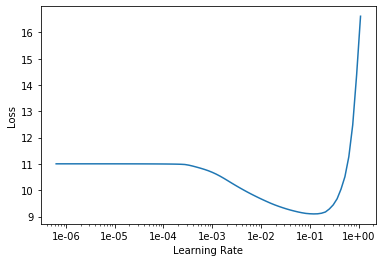

In [27]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr

0.026666666666666665

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(20, lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,4.596952,4.561115,0.270675,20:04
1,4.383838,4.382571,0.281346,20:03
2,4.410350,4.410259,0.277289,20:04
3,4.425513,4.443115,0.274180,20:04
4,4.456727,4.464992,0.271799,20:03
5,4.460025,4.457753,0.271660,20:03
6,4.411688,4.432618,0.273121,20:04
7,4.395292,4.421016,0.273847,20:03
8,4.366452,4.385614,0.276654,20:03
9,4.335859,4.354411,0.279353,20:04


Better model found at epoch 0 with accuracy value: 0.27067533135414124.
Better model found at epoch 1 with accuracy value: 0.2813456952571869.
Better model found at epoch 10 with accuracy value: 0.28191810846328735.
Better model found at epoch 11 with accuracy value: 0.2857142686843872.
Better model found at epoch 12 with accuracy value: 0.2891688644886017.
Better model found at epoch 13 with accuracy value: 0.2935861349105835.
Better model found at epoch 14 with accuracy value: 0.29742497205734253.
Better model found at epoch 15 with accuracy value: 0.3017626702785492.


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,4.033121,4.135418,0.298549,20:03
1,4.275217,4.313124,0.283684,20:02


Better model found at epoch 0 with accuracy value: 0.29854872822761536.


In [ ]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/'20epoch_hi_wt', with_opt=False)

In [ ]:
learn.data.vocab.save(mdl_path/('20epoch_hi_vocab' + '.pkl'))

### Hindi Sentiment Analysis

## BBC Articles(Hindi)

#### Language Model

We are gonna perform sentiment analysis on 2 datasets: BBC news articles,IIT-P movie reviews and IIT-P product reviews. The datasets can be found [here](https://github.com/AI4Bharat/indicnlp_corpus#publicly-available-classification-datasets).

In [27]:
train_df = pd.read_csv('data/bbc-articles-hi/hi-train.csv', header=None)
train_df.head()

,0,1
0,india,मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से...
1,pakistan,नेटिजन यानि इंटरनेट पर सक्रिय नागरिक अब ट्विटर...
2,news,इसमें एक फ़्लाइट एटेनडेंट की मदद की गुहार है औ...
3,india,"प्रतीक खुलेपन का, आज़ाद ख्याली का और भीड़ से अ..."
4,india,ख़ासकर पिछले 10 साल तक प्रधानमंत्री रहे मनमोहन...


In [28]:
test_df = pd.read_csv('data/bbc-articles-hi/hi-test.csv', header=None)
test_df.head()

,0,1
0,india,बुधवार को राज्य सभा में विपक्ष के सवालों के जव...
1,india,लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...
2,india,लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...
3,international,हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...
4,india,आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...


In [29]:
df = pd.concat([train_df,test_df], sort=False)

In [58]:
data_lm = (TextList.from_df(df, path, cols=1)
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [37]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [38]:
lr = 1e-3
lr *= bs/48

In [39]:
# finetuning the language model
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.429507,4.066370,0.291303,01:06
1,4.114826,3.962841,0.301713,01:06


In [40]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.925475,3.930910,0.305314,01:07
1,3.882566,3.891310,0.309718,01:06
2,3.819858,3.862531,0.313200,01:06
3,3.753082,3.844485,0.315466,01:06
4,3.677970,3.832285,0.317484,01:06
5,3.621572,3.827234,0.318892,01:06
6,3.591659,3.825799,0.319171,01:06
7,3.590563,3.827231,0.319184,01:06


In [41]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

In [65]:
learn_lm = None
learn = None
gc.collect()

42

### Classifier

In [42]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols=1)
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [13]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

In [67]:
data_clas.classes, data_clas.c

(['business',
  'china',
  'entertainment',
  'india',
  'institutional',
  'international',
  'learningenglish',
  'multimedia',
  'news',
  'pakistan',
  'science',
  'social',
  'southasia',
  'sport'],
 14)

In [14]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='micro')

mcc = MatthewsCorreff()

In [15]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1, mcc]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [16]:
lr=2e-2
lr *= bs/48

In [17]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,1.198869,1.184566,0.552023,0.552023,0.381528,00:23
1,0.869197,0.722998,0.748555,0.748555,0.653513,00:21


In [18]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.704260,0.755434,0.763006,0.763006,0.679601,00:22
1,0.659796,0.586382,0.820809,0.820809,0.759722,00:23


In [19]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.665057,0.687979,0.791907,0.791907,0.723031,00:26
1,0.567432,0.567387,0.823699,0.823699,0.768312,00:26


In [20]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.416406,0.601812,0.809249,0.809249,0.746467,00:35
1,0.328328,0.576490,0.820809,0.820809,0.759892,00:39


In [21]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.186924,0.615390,0.832370,0.832370,0.776217,00:46
1,0.160297,0.629750,0.838150,0.838150,0.784047,00:44


In [22]:
learn_c.save(f'{lang}clas')

In [25]:
learn_c.load(f'{lang}clas');

RNNLearner(data=TextClasDataBunch;

Train: LabelList (3121 items)
x: TextList
xxbos मेट्रो की इस लाइन के चलने से दक्षिणी दिल्ली से नोएडा जाने का समय काफी कम हो जाएगा और यात्रियों को राजीव चौक या मंडी हाउस से होकर नहीं जाना पड़ेगा . लेकिन , यह xxunk लाइन इसलिए भी महत्वपूर्ण है क्योंकि इस पर xxunk यानी बिना ड्राइवर वाली मेट्रो चलाने की योजना है . ऐसा भारत में पहली बार होगा जब कोई मेट्रो बिना ड्राइवर के चलाई जाएगी . मेट्रो के तीसरे xxunk में भारत में पहली बार ड्राइवरलेस तकनीक आएगी लेकिन दुनिया भर में कई देशों में ड्राइवरलेस मेट्रो पहले से ही चलती हैं . इन देशों में ड्राइवरलेस मेट्रो सफल भी रही हैं . दक्षिण कोरिया की राजधानी सोल में xxunk ट्रेन कामयाबी से चल रही है . ये मेट्रो ज़मीन के नीचे चलती है इसमें ड्राइवर का केबिन भी नहीं होता है . यूरोप में डेनमार्क , स्पेन , इटली , फ्रांस , जर्मनी , हंगरी , स्विट्जरलैंड और ब्रिटेन में भी xxunk मेट्रो चलती है . इन देशों में एक से ज़्यादा शहरों में भी ऐसी मेट्रो चलाई जाती है . इनके अलावा अमेरिका और कनाडा में भी ड्राइवरलेस ट्रेन चलती है . वहीं , ब्रा

In [59]:
data_valid = (TextList.from_df(test_df, path, vocab=data_lm.vocab, cols=1)
    .no_split()
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=1))

/opt/anaconda3/lib/python3.7/site-packages/fastai/data_block.py:183: UserWarning: `no_split` is deprecated, please use `split_none`.
  warn("`no_split` is deprecated, please use `split_none`.")


In [60]:
data_valid

TextClasDataBunch;

Train: LabelList (866 items)
x: TextList
xxbos बुधवार को राज्य सभा में विपक्ष के सवालों के जवाब में मनमोहन सिंह ने कहा , " अगर किसी तरह की गड़बड़ी पाई जाती है , तो हम कड़ी से कड़ी कार्रवाई करेंगे . "मंगलवार को संसद में भारत के नियंत्रक और महालेखा परीक्षक की रिपोर्ट पेश की गई है . किसानों के क़र्ज़ की माफ़ी स्कीम पर तैयार इस रिपोर्ट में कहा गया है कि पिछले वित्तीय वर्ष में जितने भी लोगों के क़र्ज़ बैंकों ने माफ़ किए थे , उनमें से 22 फ़ीसद मामले फर्ज़ी थे . रिपोर्ट में कहा गया है कि बैंक के कर्मचारियों ने फर्ज़ी खातों में कर्ज़ माफ़ किए हैं और वो सारी राशि ख़ुद xxunk ली है . विपक्ष ने मामले पर सरकार को घेरना शुरू कर दिया है . मुख्य विपक्षी दल भारतीय जनता पार्टी के प्रवक्ता प्रकाश जावडेकर ने कहा है कि इस तरह की गड़बड़ी इतने बड़े पैमाने पर सिर्फ़ तकनीकी कमियों की वजह से नहीं हो सकती है . विपक्ष और सरकार को समर्थन दे रहे xxunk जैसे समाजवादी पार्टी मामले को संसद में भी उठा रही है . लोकसभा में विपक्ष की नेता सुषमा स्वराज ने अध्यक्ष से मामले पर बहस करवाने की मांग की है . मह

In [61]:
%%time
from sklearn.metrics import accuracy_score, matthews_corrcoef
df_dict = {'query': list(test_df[1]), 'actual_label': list(test_df[0]), 'predicted_label': ['']*test_df.shape[0]}
all_nodes = list(set(train_df[0]))
for node in all_nodes:
    df_dict[node] = ['']*test_df.shape[0]
    
i2c = {}
for key, value in learn_c.data.c2i.items():
    i2c[value] = key
    
df_result = pd.DataFrame(df_dict)
for index, row in df_result.iterrows():
    pred = learn_c.predict(data_valid.train_ds[index])
    for node in all_nodes:
        row[node] = pred[2][learn_c.data.c2i[node]].item()
    row['predicted_label'] = i2c[pred[0].data.item()]
df_result.head()

,query,actual_label,predicted_label,india,international,business,entertainment,news,pakistan,sport,china,learningenglish,southasia,social,multimedia,institutional,science
0,बुधवार को राज्य सभा में विपक्ष के सवालों के जव...,india,india,0.99837,0.000105902,0.000898691,1.32681e-05,0.000352362,1.24156e-05,0.000142646,1.69676e-06,2.2648e-08,8.80532e-05,5.61723e-07,1.16179e-05,1.0053e-06,1.78515e-06
1,लखनऊ स्थित पत्रकार समीरात्मज मिश्र को बुलंदशहर...,india,india,0.999609,9.95603e-05,1.72562e-06,1.24778e-06,1.65007e-05,1.79436e-06,0.000261029,3.25504e-07,1.8079e-08,2.4526e-06,2.64633e-07,5.35698e-06,2.97535e-07,9.23659e-07
2,लगभग 1300 हेक्टेयर ज़मीन का अधिग्रहण किया जा च...,india,india,0.998489,0.000125899,5.74076e-06,0.000591447,0.00049142,2.80877e-06,5.12592e-06,1.60039e-06,1.72318e-08,1.93073e-05,5.42383e-07,0.000259593,1.71028e-06,5.67388e-06
3,हालांकि उनके अंगरक्षकों को बमों को जाम करने वा...,international,international,0.000194536,0.999052,1.77967e-05,9.84898e-05,0.000104535,7.7294e-06,5.4925e-05,1.87943e-06,1.31205e-06,3.55316e-05,3.26007e-06,0.000300275,4.02626e-05,8.70869e-05
4,आयोग का कहना है कि इस तरह के परीक्षण से महिलाओ...,india,india,0.782914,0.148549,0.00140876,0.0106771,0.0107084,0.00477509,0.0064068,0.00356244,8.02568e-05,0.0213587,0.0012408,0.00648865,0.00087472,0.000955079


In [64]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 17 columns):
query              866 non-null object
actual_label       866 non-null object
predicted_label    866 non-null object
india              866 non-null object
international      866 non-null object
business           866 non-null object
entertainment      866 non-null object
news               866 non-null object
pakistan           866 non-null object
sport              866 non-null object
china              866 non-null object
learningenglish    866 non-null object
southasia          866 non-null object
social             866 non-null object
multimedia         866 non-null object
institutional      866 non-null object
science            866 non-null object
dtypes: object(17)
memory usage: 115.1+ KB


In [62]:
accuracy_score(df_result['actual_label'], df_result['predicted_label'])

0.7979214780600462

In [63]:
matthews_corrcoef(df_result['actual_label'], df_result['predicted_label'])

0.7258121928549706

In [69]:
f1_score(df_result['actual_label'], df_result['predicted_label'], average='micro')

0.7979214780600463

## IIT-P Product Reviews

In [104]:
train_df = pd.read_csv('data/iitp-product-reviews/hi-train.csv', header=None)
train_df.head()

,0,1
0,negative,एंडराॅयड के मामले में यह थोड़ा पीछे है ।
1,neutral,यह एस्पेक्ट रेशो का ईश्यू है और हम आशा करते है...
2,positive,लेकिन इस तरह के एक मॉडल के एक घर कंप्यूटर के ल...
3,positive,गिर वन राष्ट्रीय उद्यान बाघ संरक्षित क्षेत्र ह...
4,neutral,"और हां , इस फिल्म में हर किरदार भारद्वाज को भर..."


In [105]:
valid_df = pd.read_csv('data/iitp-product-reviews/hi-valid.csv', header=None)
valid_df.head()

,0,1
0,positive,"एक ऐसा भी जानवर है , जिसे आप पसंद तो करते होंग..."
1,neutral,इतना नहीं बल्कि यहां पर कंपनी अपना पहला फाइव स...
2,neutral,"डिजिफलीप प्रो XT811 , 1200 x 800 P और 8 इंच डि..."
3,positive,निकोन डी810 कैमरे की सबसे खास बात ये है कि इसम...
4,positive,"इसमें विंडोज 8 64-बिट ऑपरेटिंग सिस्टम है , लेक..."


In [106]:
test_df = pd.read_csv('data/iitp-product-reviews/hi-test.csv', header=None)
test_df.head()

,0,1
0,neutral,"मगर , इस तरफ कोई ध्यान नहीं दिया जा रहा ।"
1,negative,गेम कई बार मुश्किल मालूम देता है ।
2,negative,मल्टीप्लेयर में छोटी स्टोरीलाइन है ।
3,positive,हाई - एंड एचपी नोटबुक्स की लुक्स हमेशा बेहतरीन...
4,positive,कैमरे बनाने वाली कंपनी निकोन अपनी 1 सीरीज कैमर...


In [107]:
df = pd.concat([train_df,test_df, valid_df], sort=False)

In [108]:
data_lm = (TextList.from_df(df, path, cols=1)
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [109]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [110]:
lr = 1e-3
lr *= bs/48

In [111]:
# finetuning the language model
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.091315,4.147563,0.277734,00:02
1,4.614954,3.878611,0.322935,00:02


In [112]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.077450,3.800886,0.329241,00:02
1,4.020785,3.710403,0.337556,00:02
2,3.948716,3.658453,0.339955,00:02
3,3.882256,3.621788,0.340960,00:02
4,3.826952,3.599216,0.343304,00:02
5,3.780982,3.584149,0.344754,00:02
6,3.745140,3.581907,0.344531,00:02
7,3.711502,3.582035,0.344029,00:02


In [113]:
learn_lm.save(f'{lang}fine_tuned_product_reviews')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_product_reviews')

In [114]:
learn_lm = None
learn = None
gc.collect()

100

### Classifier

In [115]:
product_reviews = pd.concat([train_df,valid_df], sort=False)

In [116]:
data_clas = (TextList.from_df(product_reviews, path, vocab=data_lm.vocab, cols=1)
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class_product_reviews')

In [117]:
data_clas = load_data(path, f'{lang}_textlist_class_product_reviews', bs=bs, num_workers=1)

In [118]:
data_clas.classes, data_clas.c

(['negative', 'neutral', 'positive'], 3)

In [119]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='micro')

mcc = MatthewsCorreff()

In [120]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1, mcc]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_product_reviews')
learn_c.freeze()

In [121]:
lr=2e-2
lr *= bs/48

In [122]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.867476,0.850812,0.551064,0.551064,0.217420,00:01
1,0.785490,0.722760,0.672340,0.672340,0.444385,00:01


In [123]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.771300,0.732296,0.668085,0.668085,0.432283,00:01
1,0.732997,0.685178,0.676596,0.676596,0.448859,00:01


In [124]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.745818,0.687766,0.689362,0.689362,0.493372,00:01
1,0.637387,0.632487,0.727660,0.727660,0.551949,00:01


In [125]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.513728,0.705725,0.687234,0.687234,0.507177,00:01
1,0.411362,0.733756,0.712766,0.712766,0.534596,00:01


In [126]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.272120,0.760782,0.729787,0.729787,0.554179,00:02
1,0.245084,0.738876,0.738298,0.738298,0.562510,00:02


In [128]:
learn_c.save(f'{lang}clas_product_reviews')

In [129]:
learn_c.load(f'{lang}clas_product_reviews');

In [130]:
data_valid = (TextList.from_df(test_df, path, vocab=data_lm.vocab, cols=1)
    .split_none()
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=1))

In [131]:
data_valid

TextClasDataBunch;

Train: LabelList (523 items)
x: TextList
xxbos मगर , इस तरफ कोई ध्यान नहीं दिया जा रहा ।,xxbos गेम कई बार मुश्किल मालूम देता है ।,xxbos xxunk में छोटी xxunk है ।,xxbos हाई - एंड एचपी नोटबुक्स की लुक्स हमेशा बेहतरीन होती है – अत्याधुनिक और xxunk लुक जो हर किसी को xxunk हैं ।,xxbos कैमरे बनाने वाली कंपनी निकोन अपनी 1 सीरीज कैमरों में xxunk करते हुए इस सीरीज का सबसे शानदार कैमरा लेकर आई है ।
y: CategoryList
neutral,negative,negative,positive,positive
Path: /home/jupyter/.fastai/data/hiwiki;

Valid: LabelList (0 items)
x: TextList

y: CategoryList

Path: /home/jupyter/.fastai/data/hiwiki;

Test: None

In [132]:
%%time
from sklearn.metrics import accuracy_score, matthews_corrcoef
df_dict = {'query': list(test_df[1]), 'actual_label': list(test_df[0]), 'predicted_label': ['']*test_df.shape[0]}
all_nodes = list(set(train_df[0]))
for node in all_nodes:
    df_dict[node] = ['']*test_df.shape[0]
    
i2c = {}
for key, value in learn_c.data.c2i.items():
    i2c[value] = key
    
df_result = pd.DataFrame(df_dict)
for index, row in df_result.iterrows():
    pred = learn_c.predict(data_valid.train_ds[index])
    for node in all_nodes:
        row[node] = pred[2][learn_c.data.c2i[node]].item()
    row['predicted_label'] = i2c[pred[0].data.item()]
df_result.head()

CPU times: user 24.8 s, sys: 124 ms, total: 24.9 s
Wall time: 24.9 s


,query,actual_label,predicted_label,neutral,positive,negative
0,"मगर , इस तरफ कोई ध्यान नहीं दिया जा रहा ।",neutral,neutral,0.7905,0.000651227,0.208849
1,गेम कई बार मुश्किल मालूम देता है ।,negative,negative,0.00432524,0.000716321,0.994958
2,मल्टीप्लेयर में छोटी स्टोरीलाइन है ।,negative,negative,0.39135,0.0483416,0.560309
3,हाई - एंड एचपी नोटबुक्स की लुक्स हमेशा बेहतरीन...,positive,positive,5.19448e-05,0.999905,4.28122e-05
4,कैमरे बनाने वाली कंपनी निकोन अपनी 1 सीरीज कैमर...,positive,positive,0.0098381,0.989887,0.000275296


In [133]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 6 columns):
query              523 non-null object
actual_label       523 non-null object
predicted_label    523 non-null object
neutral            523 non-null object
positive           523 non-null object
negative           523 non-null object
dtypes: object(6)
memory usage: 24.6+ KB


In [134]:
accuracy_score(df_result['actual_label'], df_result['predicted_label'])

0.7208413001912046

In [135]:
matthews_corrcoef(df_result['actual_label'], df_result['predicted_label'])

0.5419081520416014

In [136]:
f1_score(df_result['actual_label'], df_result['predicted_label'], average='micro')

0.7208413001912046

## IIT-P movie reviews

In [137]:
train_df = pd.read_csv('data/iit-p-movie-reviews/hi-train.csv', header=None)
train_df.head()

,0,1
0,neutral,"निर्माता :\nशीतल विनोद तलवार, मधु‍ मैंटेना\n\n..."
1,positive,’उड़ान’ से विक्रमादित्य\nमोटवाने\nने अच्छे सिन...
2,neutral,फिल्म में गानों के दृश्य में अनुष्का को माइक क...
3,neutral,फांसी चढ़ने से पहले वह पाकिस्तान के सदर से खास...
4,positive,राज कुमार हिरानी ने इस मूवी में भी अपने डायरेक...


In [139]:
valid_df = pd.read_csv('data/iit-p-movie-reviews/hi-valid.csv', header=None)
valid_df.head()

,0,1
0,negative,"ये फगली-फगली क्या है, ये फगली-फगली? इस बात का ..."
1,neutral,निर्माता :\nआदित्य चोपड़ा\n\nनिर्देशक :\nहबीब ...
2,positive,इस कसौटी पर करण काफी हद तक खरे भी उतरे हैं।
3,positive,"छोटे शहर की गालियां, छतें और विहंगम दृश्य मोहक..."
4,positive,मनीष और जिशान का काम भी लोगों को याद रहेगा।


In [138]:
test_df = pd.read_csv('data/iit-p-movie-reviews/hi-test.csv', header=None)
test_df.head()

,0,1
0,negative,काव्या अपनी खुन्नस और जिद में सिद्धार्थ को तबा...
1,negative,"निर्माता :\nफरहान अख्तर, रितेश सिधवानी\n\nनिर्..."
2,positive,असमर्पित रिश्ते में यकीन रखने वाले दोनों मौज-म...
3,neutral,"बेवकूफियां को हबीब फैज़ल ने लिखा है, जिनका नाम..."
4,neutral,तब वह मोटी थी और जेरी ने उस पर ध्यान नहीं दिय...


In [140]:
df = pd.concat([train_df,test_df, valid_df], sort=False)

In [141]:
data_lm = (TextList.from_df(df, path, cols=1)
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [142]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [143]:
lr = 1e-3
lr *= bs/48

In [144]:
# finetuning the language model
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.507449,3.963688,0.306794,00:16
1,4.120755,3.851468,0.316643,00:16


In [145]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.884935,3.817736,0.320745,00:16
1,3.834695,3.756623,0.327623,00:16
2,3.758144,3.702843,0.334738,00:16
3,3.663788,3.665003,0.339704,00:16
4,3.590355,3.641516,0.342885,00:16
5,3.531239,3.633370,0.343862,00:16
6,3.496819,3.625730,0.344838,00:16
7,3.476408,3.627779,0.344866,00:16


In [146]:
learn_lm.save(f'{lang}fine_tuned_movie_reviews')
learn_lm.save_encoder(f'{lang}fine_tuned_enc_movie_reviews')

In [147]:
learn_lm = None
learn = None
gc.collect()

78

### Classifier

In [148]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols=1)
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class_movie_reviews')

In [149]:
data_clas = load_data(path, f'{lang}_textlist_class_movie_reviews', bs=bs, num_workers=1)

In [150]:
data_clas.classes, data_clas.c

(['negative', 'neutral', 'positive'], 3)

In [151]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1), average='micro')

mcc = MatthewsCorreff()

In [152]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1, mcc]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc_movie_reviews')
learn_c.freeze()

In [153]:
lr=2e-2
lr *= bs/48

In [154]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,1.086575,1.088551,0.443548,0.443548,0.127183,00:07
1,0.993112,1.009850,0.455645,0.455645,0.146455,00:07


In [155]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.978189,0.991457,0.508065,0.508065,0.247321,00:07
1,0.942549,0.965854,0.536290,0.536290,0.304887,00:06


In [156]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.928373,1.130748,0.483871,0.483871,0.201155,00:09
1,0.846182,0.968071,0.584677,0.584677,0.373331,00:08


In [157]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.671158,1.011002,0.596774,0.596774,0.418545,00:10
1,0.586543,0.880956,0.600806,0.600806,0.398368,00:15


In [158]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,matthews_correff,time
0,0.375172,0.876832,0.633065,0.633065,0.448443,00:16
1,0.335480,0.962638,0.629032,0.629032,0.453694,00:13


In [159]:
learn_c.save(f'{lang}clas_movie_reviews')

In [160]:
learn_c.load(f'{lang}clas_movie_reviews');

In [161]:
data_valid = (TextList.from_df(test_df, path, vocab=data_lm.vocab, cols=1)
    .split_none()
    .label_from_df(cols=0)
    .databunch(bs=bs, num_workers=1))

In [162]:
data_valid

TextClasDataBunch;

Train: LabelList (310 items)
x: TextList
xxbos काव्या अपनी xxunk और जिद में सिद्धार्थ को तबाह करने के लिए जिस्म को हथियार बनाती है ।,xxbos निर्माता : 
  फरहान अख्तर , रितेश सिधवानी 
 
  निर्देशक : 
  अभिनय देव 
 
  संगीत : 
  शंकर - अहसान - लॉय 
 
  कलाकार : 
  अभिषेक बच्चन , कंगना , xxunk जेन xxunk , जिमी शेरगिल , गौहर खान , शहाना गोस्वामी , बोमन ईरानी , अनुपम खेर 
 
  सेंसर सर्टिफिकेट : यू / ए * 2 घंटे 10 मिनट 
 
 
 
  थ्रिलर और मर्डर मिस्ट्री फिल्म बनाना हर किसी के बस की बात नहीं है । राज खुलने तक दर्शक को बाँधकर रखना और कातिल के चेहरे से परदा xxunk के बाद दर्शक को संतुष्ट करना कठिन काम है क्योंकि सभी को अपने प्रश्नों का ठोस उत्तर xxunk । इसके लिए कसी हुई स्क्रिप्ट और चुस्त निर्देशन की आवश्यकता होती है । 
 
  ‘ गेम ’ इन xxunk पर खरी नहीं उतरती और एक उबाऊ फिल्म के रूप में सामने आती है । हैरत इस बात की होती है कि इस फिल्म से फरहान अख्तर का नाम जुड़ा है जिनका बैनर अच्छी फिल्मों के लिए जाना जाता है । 
 
  फिल्म से जुड़े सारे लोगों का ध्यान केवल स्टाइलिश फिल्म बनाने क

In [163]:
%%time
from sklearn.metrics import accuracy_score, matthews_corrcoef
df_dict = {'query': list(test_df[1]), 'actual_label': list(test_df[0]), 'predicted_label': ['']*test_df.shape[0]}
all_nodes = list(set(train_df[0]))
for node in all_nodes:
    df_dict[node] = ['']*test_df.shape[0]
    
i2c = {}
for key, value in learn_c.data.c2i.items():
    i2c[value] = key
    
df_result = pd.DataFrame(df_dict)
for index, row in df_result.iterrows():
    pred = learn_c.predict(data_valid.train_ds[index])
    for node in all_nodes:
        row[node] = pred[2][learn_c.data.c2i[node]].item()
    row['predicted_label'] = i2c[pred[0].data.item()]
df_result.head()

CPU times: user 23.1 s, sys: 1.59 s, total: 24.6 s
Wall time: 24.2 s


,query,actual_label,predicted_label,neutral,positive,negative
0,काव्या अपनी खुन्नस और जिद में सिद्धार्थ को तबा...,negative,neutral,0.784352,0.0492201,0.166428
1,"निर्माता :\nफरहान अख्तर, रितेश सिधवानी\n\nनिर्...",negative,negative,0.10598,0.00492299,0.889097
2,असमर्पित रिश्ते में यकीन रखने वाले दोनों मौज-म...,positive,neutral,0.725661,0.0104935,0.263846
3,"बेवकूफियां को हबीब फैज़ल ने लिखा है, जिनका नाम...",neutral,negative,0.0610749,0.0156547,0.92327
4,तब वह मोटी थी और जेरी ने उस पर ध्यान नहीं दिय...,neutral,neutral,0.58743,0.0982174,0.314352


In [164]:
df_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 6 columns):
query              310 non-null object
actual_label       310 non-null object
predicted_label    310 non-null object
neutral            310 non-null object
positive           310 non-null object
negative           310 non-null object
dtypes: object(6)
memory usage: 14.7+ KB


In [165]:
accuracy_score(df_result['actual_label'], df_result['predicted_label'])

0.5838709677419355

In [166]:
matthews_corrcoef(df_result['actual_label'], df_result['predicted_label'])

0.3834258064691419

In [167]:
f1_score(df_result['actual_label'], df_result['predicted_label'], average='micro')

0.5838709677419355